# Usando modelos de Árvore (Decision Tree Classifier) e Vizinhos  Mais Próximos (KNN) para classificar times de baseball em eliminações

## Importando bibliotecas

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

SEED = 42

## Carregando dados

In [5]:
df_raw = pd.read_csv('../dados/baseball.csv')
df_raw.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


### Dicionário de dados:
- Team: time
- League: liga
- Year: ano
- Runs Scored (RS): corridas pontuadas por completar as bases
- Runs Allowed (RA): corridas pontuadas contra o arremessador
- Wins (W): total de vitórias do arremessador
- On-Base Percentage(OBP): mede o quão frequentemente um rebatedor atinge a base (rebatimentos + interferências + número de vezes atingido pelo arremessador / número de rodadas completadas)
- Slugging Percentage (SLG): performance do rebatedor (total de bases atingidas / total rebatimentos)
- Batting Average (BA): rebatimento médio
- Playoffs (binary): se o time foi ou não para as eliminatórias
- RankSeason: ranking de um time antes das eliminatórias
- RankPlayoffs: ranking de um time após as eliminatórias
- Games Played (G): total de partidas jogadas
- Opponent On-Base Percentage (OOBP): mede o quão frequentemente o rebatedor oponente atinge a base
- Opponent Slugging Percentage (OSLG): performance do rebatedor oponente

In [6]:
# anos presentes no dataset 
df_raw['Year'].min(), df_raw['Year'].max() # 50 anos

(1962, 2012)

In [7]:
df_raw.shape # 1232 entradas e 16 features

(1232, 15)

In [8]:
len(df_raw['Team'].unique()) # dados de 39 times

39

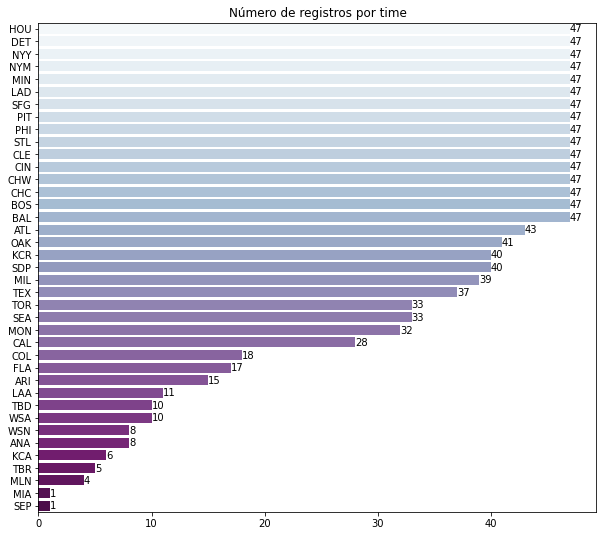

In [9]:
teams = df_raw['Team'].value_counts().index
occurences = df_raw['Team'].value_counts().values

plt.figure(figsize=(10, 9))
ax = sns.barplot(x=occurences, y=teams, data=df_raw, orient='h', palette='BuPu').set_title('Número de registros por time')
ax.axes.bar_label(ax.axes.containers[0]);

Podemos ver que há 16 times com 47 registros, nosso número máximo, e que os outros times vão decrescendo em números. Prever para os times com menos de 30 registros é arriscado e involve um grau alto de incerteza.

In [10]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,1232.0,1988.957792,14.819625,1962.000,1976.750,1989.000,2002.000,2012.000
RS,1232.0,715.081981,91.534294,463.000,652.000,711.000,775.000,1009.000
RA,1232.0,715.081981,93.079933,472.000,649.750,709.000,774.250,1103.000
W,1232.0,80.904221,11.458139,40.000,73.000,81.000,89.000,116.000
OBP,1232.0,0.326331,0.015013,0.277,0.317,0.326,0.337,0.373
SLG,1232.0,0.397342,0.033267,0.301,0.375,0.396,0.421,0.491
BA,1232.0,0.259273,0.012907,0.214,0.251,0.260,0.268,0.294
Playoffs,1232.0,0.198052,0.398693,0.000,0.000,0.000,0.000,1.000
RankSeason,244.0,3.122951,1.738349,1.000,2.000,3.000,4.000,8.000
RankPlayoffs,244.0,2.717213,1.095234,1.000,2.000,3.000,4.000,5.000


Pela estatística descritiva, podemos ver que a variabilidade de todas as features é alta.

## Criando nova feature Run Difference (RD)

Nova feature diferença das corridas (Run Difference - RD): removendo das corridas pontuadas as pontuações que aconteceram por causa do arremessador.


In [11]:
df_raw['RD'] = df_raw['RS'] - df_raw['RA']
df_raw.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415,46
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378,100
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403,7
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428,-72
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424,-146


## Olhando as combinações de variáveis e suas distribuições

Features combinadas em pares com pontos coloridos de acordo com os Playoffs


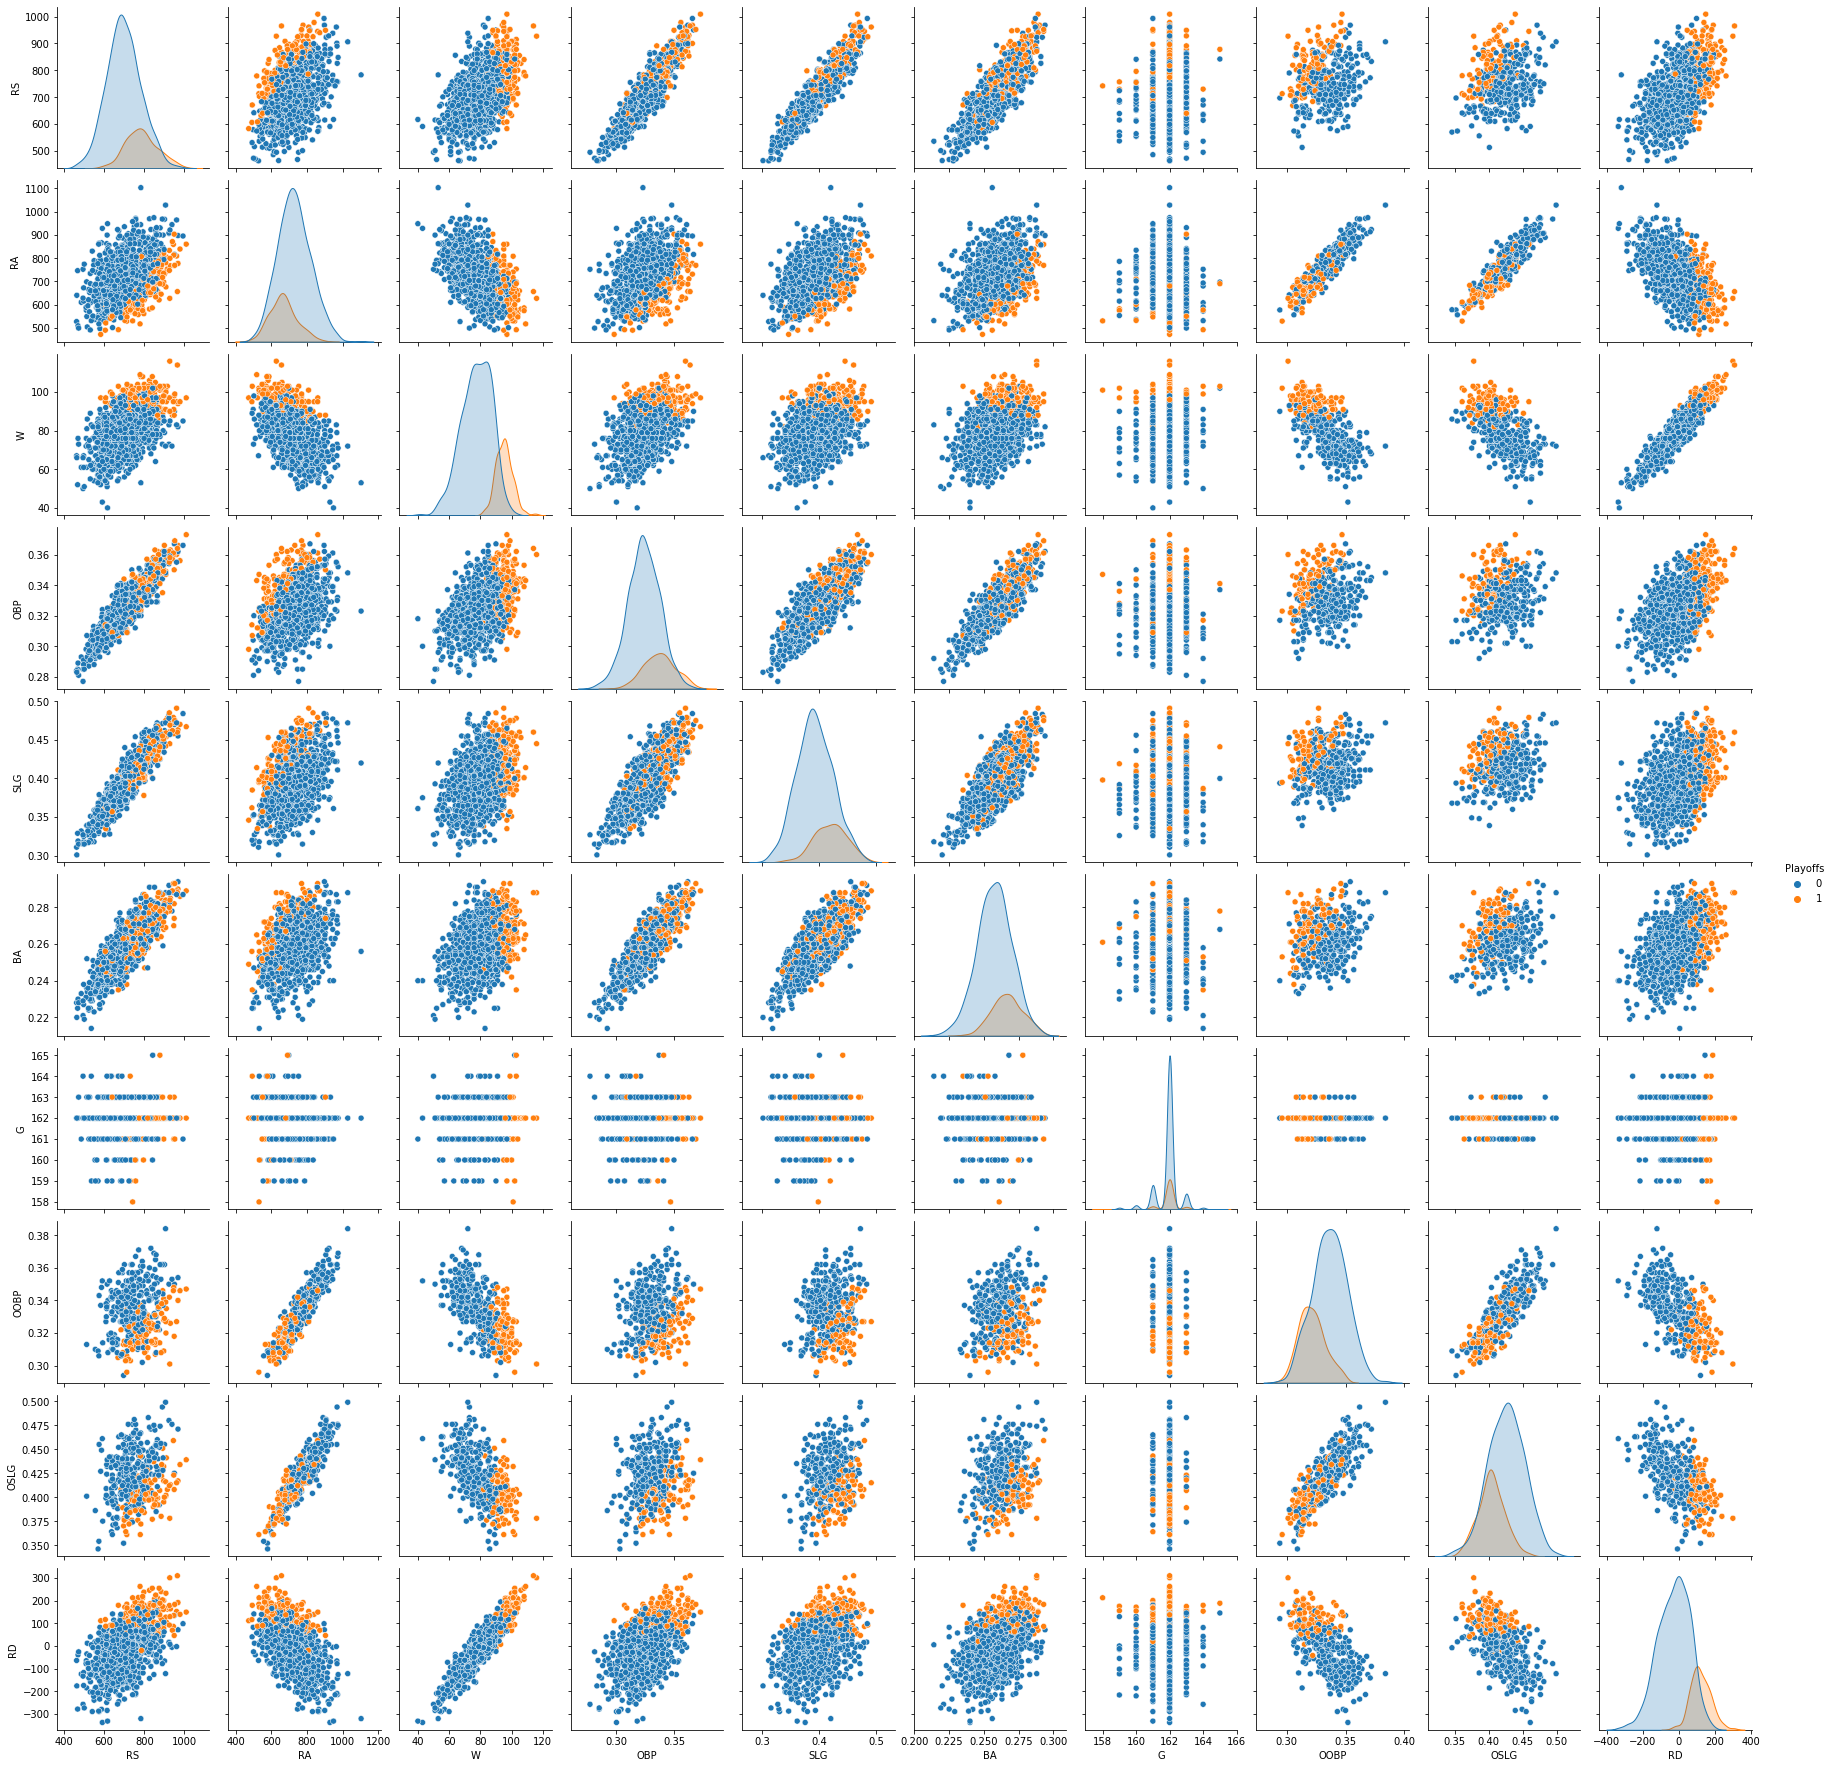

In [12]:
excluded_cols = ['Team', 'League', 'Year', 'RankSeason', 'RankPlayoffs']

print('Features combinadas em pares com pontos coloridos de acordo com os Playoffs')
sns.pairplot(data=df_raw.drop(excluded_cols, axis=1), hue='Playoffs');

Team


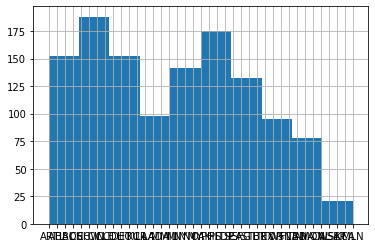

League


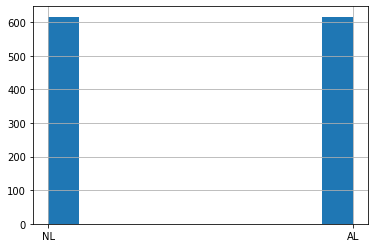

Year


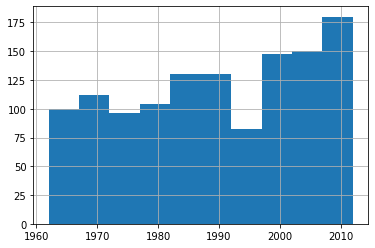

RS


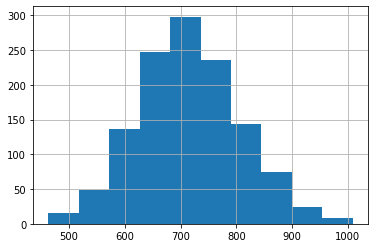

RA


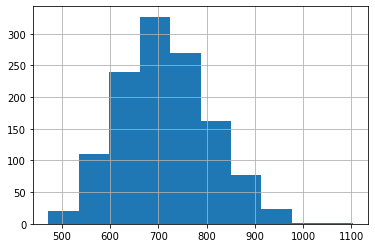

W


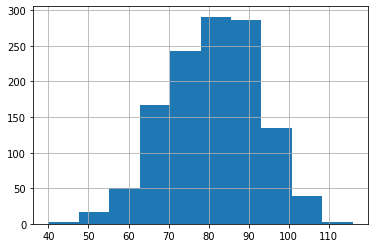

OBP


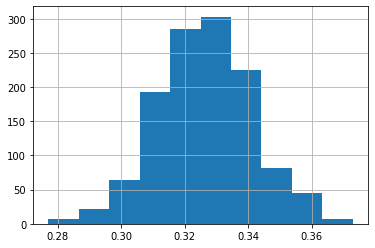

SLG


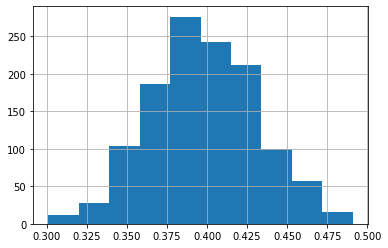

BA


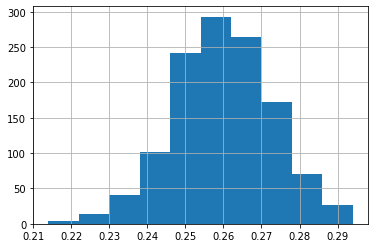

Playoffs


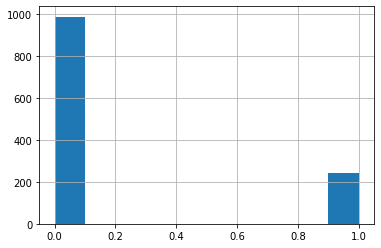

RankSeason


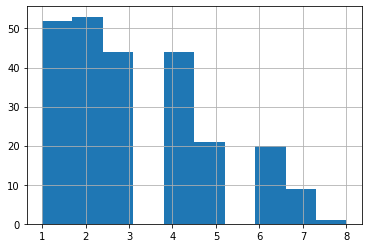

RankPlayoffs


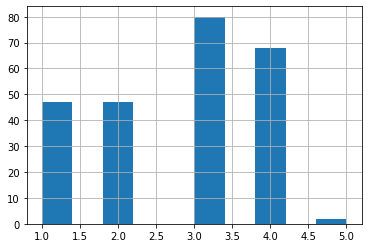

G


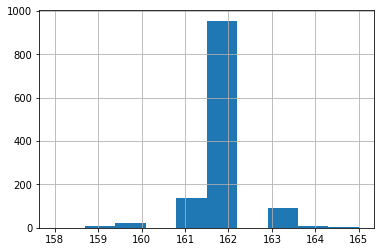

OOBP


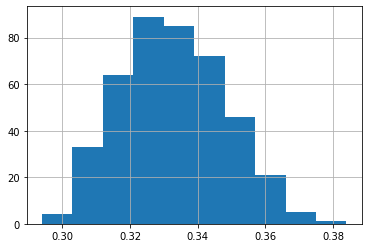

OSLG


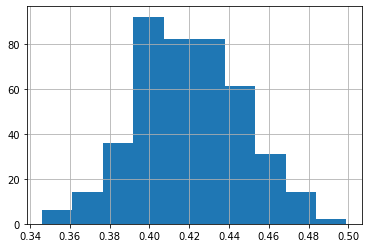

RD


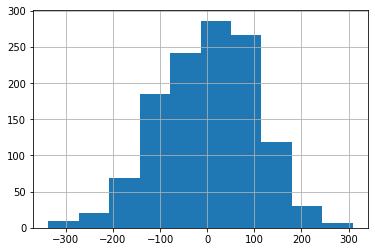

In [13]:
for col in df_raw.columns:
    print(col)
    df_raw[col].hist()
    plt.show();

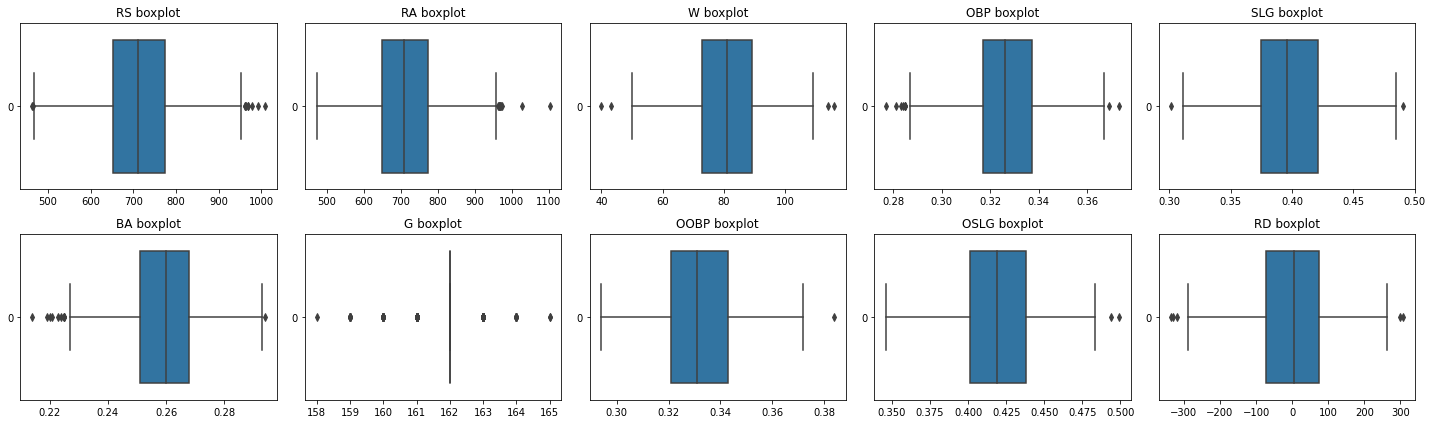

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,6))
exclud_cols = ['Team', 'League', 'Year', 'RankSeason', 'RankPlayoffs', 'Playoffs']
box_cols = df_raw.drop(exclud_cols, axis=1).columns

for ax, x in zip(axes.flatten(), box_cols):
    sns.boxplot(data=df_raw[x], ax=ax, orient='h')
    ax.set_title(f'{x} boxplot', pad=7)
    plt.tight_layout()

Podemos ver pelo pairplot, boxplot e pelos histogramas que as features com melhores distribuições, correlações e que fazem sentido para o nosso modelo são 'RS', 'RA', OBP', 'SLG', 'BA' e 'RD'. No entanto, RD já é uma combinação de RS e RA, logo iremos usar apenas a nova feature RD.

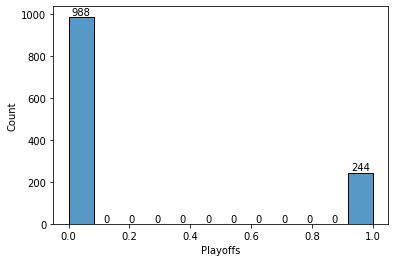

In [15]:
ax = sns.histplot(df_raw['Playoffs'])
ax.axes.bar_label(ax.axes.containers[0]);

Repare que nosso target é desbalanceado. Há muito mais dados de times que não chegam nos playoffs (968) do que aqueles que chegam (244).

## Dividindo dados em treino e teste

In [16]:
features = ['OBP', 'SLG', 'BA', 'RD']
target = ['Playoffs']

In [17]:
X = df_raw[features]
y = df_raw[target]

In [18]:
split_test_size = 0.3 # 30% separado para teste

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=split_test_size,
                                                    random_state=SEED)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((862, 4), (370, 4), (862, 1), (370, 1))

## Modelo de Árvore de decisão

In [20]:
depths = [2, 3, 4, 5, 10, 15]
for d in depths:
    dtc = DecisionTreeClassifier(max_depth=d)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)
    print(f'Profundidade igual a {d}')
    print(f'Acurácia de treino: {dtc.score(X_train, y_train):.2f}')
    print(f'Acurácia de teste: {dtc.score(X_test, y_test):.2f}')
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('-'*70)
    print('\n')

Profundidade igual a 2
Acurácia de treino: 0.88
Acurácia de teste: 0.88
[[261  29]
 [ 17  63]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       290
           1       0.68      0.79      0.73        80

    accuracy                           0.88       370
   macro avg       0.81      0.84      0.83       370
weighted avg       0.88      0.88      0.88       370

----------------------------------------------------------------------


Profundidade igual a 3
Acurácia de treino: 0.89
Acurácia de teste: 0.88
[[271  19]
 [ 26  54]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       290
           1       0.74      0.68      0.71        80

    accuracy                           0.88       370
   macro avg       0.83      0.80      0.81       370
weighted avg       0.88      0.88      0.88       370

----------------------------------------------------------------------


Profundida

Fazendo uma rápida verificação, apenas com a profundidade da árvore, podemos perceber que ela só não sobreajustou para o primeiro modelo com profundidade 2.
Portanto, iremos usar um grid search para tentar encontrar os melhores hiperparâmetros. No nosso caso, queremos encontrar todos os times possíveis e também os melhores times para os playoffs, então, maximizar o f1-score.

Como também temos poucas amostras dos times ganhadores, iremos testar uma busca em grade para uma precisão maximizada.

### Modelo que maximiza f1

In [159]:
parameters = {'max_depth':[2, 3, 4, 5, 6, 7],
              'min_samples_leaf':[50, 40, 30, 20, 15, 10, 9, 8, 7, 6, 5]}
dt = DecisionTreeClassifier()
gs = GridSearchCV(dt, parameters, 
                  cv=10, scoring='f1', 
                  return_train_score=True)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [50, 40, 30, 20, 15, 10, 9, 8, 7,
                                              6, 5]},
             return_train_score=True, scoring='f1')

In [160]:
# melhores parâmetros de acordo com o grid search
gs.best_params_

{'max_depth': 2, 'min_samples_leaf': 50}

In [161]:
best_dtc = gs.best_estimator_

In [162]:
best_dtc.fit(X_train, y_train)
y_pred_best = best_dtc.predict(X_test)
print(f'Acurácia de treino: {best_dtc.score(X_train, y_train):.2f}')
print(f'Acurácia de teste: {best_dtc.score(X_test, y_test):.2f}')
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Acurácia de treino: 0.88
Acurácia de teste: 0.88
[[261  29]
 [ 17  63]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       290
           1       0.68      0.79      0.73        80

    accuracy                           0.88       370
   macro avg       0.81      0.84      0.83       370
weighted avg       0.88      0.88      0.88       370



In [163]:
print(best_dtc.feature_names_in_)
best_dtc.feature_importances_ # a feature mais importante é RD

['OBP' 'SLG' 'BA' 'RD']


array([0., 0., 0., 1.])

In [164]:
print(tree.export_text(best_dtc))

|--- feature_3 <= 79.50
|   |--- feature_3 <= 44.50
|   |   |--- class: 0
|   |--- feature_3 >  44.50
|   |   |--- class: 0
|--- feature_3 >  79.50
|   |--- feature_3 <= 135.00
|   |   |--- class: 1
|   |--- feature_3 >  135.00
|   |   |--- class: 1



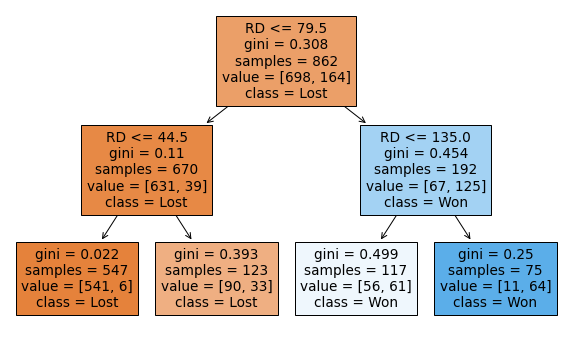

In [165]:
plt.figure(figsize=(10,6))
tree.plot_tree(best_dtc, feature_names=features, class_names=['Lost', 'Won'], filled=True);

Podemos ver que, de acordo com o modelo, para um time chegar nos Playoffs, o RD precisa ser <= 135.0. Se o RD for <= 79.5, o time já perde as chances de chegar nos playoffs.

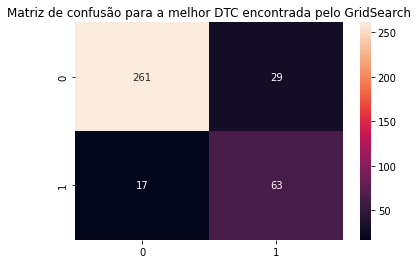

In [167]:
sns.heatmap(confusion_matrix(y_test,y_pred_best), annot=True, fmt='d').set_title('Matriz de confusão para a melhor DTC encontrada pelo GridSearch');

### Modelo que maximiza precisão

In [169]:
parameters = {'max_depth':[2, 3, 4, 5, 6, 7],
              'min_samples_leaf':[50, 40, 30, 20, 15, 10, 9, 8, 7, 6, 5]}
dtp = DecisionTreeClassifier()
gsp = GridSearchCV(dtp, parameters, 
                  cv=10, scoring='precision', 
                  return_train_score=True)
gsp.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [50, 40, 30, 20, 15, 10, 9, 8, 7,
                                              6, 5]},
             return_train_score=True, scoring='precision')

In [170]:
# melhores parâmetros de acordo com o grid search
gsp.best_params_

{'max_depth': 3, 'min_samples_leaf': 30}

In [171]:
dtcp = gsp.best_estimator_

In [173]:
dtcp.fit(X_train, y_train)
y_predp = dtcp.predict(X_test)
print(f'Acurácia de treino: {dtcp.score(X_train, y_train):.2f}')
print(f'Acurácia de teste: {dtcp.score(X_test, y_test):.2f}')
print(confusion_matrix(y_test, y_predp))
print(classification_report(y_test, y_predp))

Acurácia de treino: 0.89
Acurácia de teste: 0.88
[[272  18]
 [ 26  54]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       290
           1       0.75      0.68      0.71        80

    accuracy                           0.88       370
   macro avg       0.83      0.81      0.82       370
weighted avg       0.88      0.88      0.88       370



In [174]:
print(dtcp.feature_names_in_)
dtcp.feature_importances_ # a feature mais importante é RD

['OBP' 'SLG' 'BA' 'RD']


array([0.       , 0.0281126, 0.       , 0.9718874])

In [175]:
print(tree.export_text(dtcp))

|--- feature_3 <= 79.50
|   |--- feature_3 <= 44.50
|   |   |--- feature_1 <= 0.41
|   |   |   |--- class: 0
|   |   |--- feature_1 >  0.41
|   |   |   |--- class: 0
|   |--- feature_3 >  44.50
|   |   |--- feature_1 <= 0.39
|   |   |   |--- class: 0
|   |   |--- feature_1 >  0.39
|   |   |   |--- class: 0
|--- feature_3 >  79.50
|   |--- feature_3 <= 135.00
|   |   |--- feature_1 <= 0.40
|   |   |   |--- class: 0
|   |   |--- feature_1 >  0.40
|   |   |   |--- class: 1
|   |--- feature_3 >  135.00
|   |   |--- feature_3 <= 166.00
|   |   |   |--- class: 1
|   |   |--- feature_3 >  166.00
|   |   |   |--- class: 1



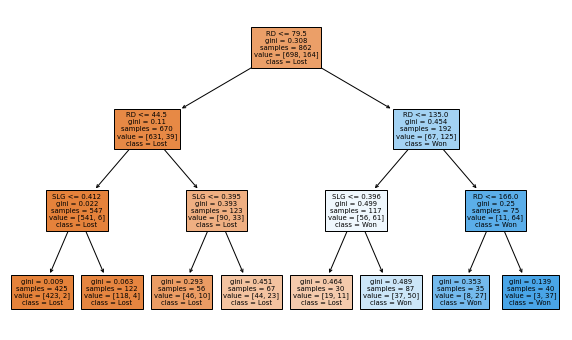

In [176]:
plt.figure(figsize=(10,6))
tree.plot_tree(dtcp, feature_names=features, class_names=['Lost', 'Won'], filled=True);

O modelo com maior precisão overfitou, no entanto, podemos ver que ele também considera a variável SLG ao invés de somente a RD. Com isso, há uma pequena mudança de valores para times serem considerados ganhadores.

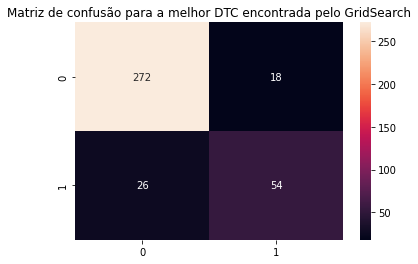

In [177]:
sns.heatmap(confusion_matrix(y_test,y_predp), annot=True, fmt='d').set_title('Matriz de confusão para a melhor DTC encontrada pelo GridSearch');

Repare que identificamos mais amostras da classe 1, agora temos 54 amostras.

## Criando outra Árvore de Decisão com uma sub-amostra balanceada do Target

Iremos repetir o processo para uma amostra com classes balanceadas.

In [34]:
# obtendo 244 amostras dos times que não foram para os playoffs
play_0_sample = df_raw[df_raw['Playoffs'] == 0].sample(244)

In [35]:
play_1_all = df_raw[df_raw['Playoffs'] == 1]

In [36]:
dfs = [play_0_sample, play_1_all]
new_df = pd.concat(dfs, axis=0)

In [37]:
new_df.shape

(488, 16)

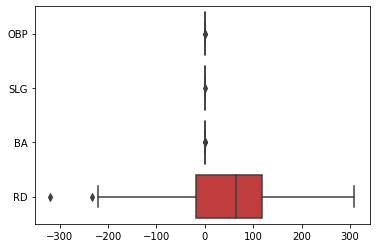

In [38]:
# podemos ver que RD é maior do que outras features, no entanto, modelos de árvore não são sensíveis a scaling
sns.boxplot(data=new_df[features], orient='h');

## Dividindo dados entre treino e teste para a nova Árvore de decisão

In [39]:
Xn = new_df[features]
yn = new_df[target]

In [40]:
split_test_size = 0.3 # 30% separado para teste

Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, 
                                                    test_size=split_test_size,
                                                    random_state=SEED)

In [154]:
parameters = {'max_depth':[2, 3, 4, 5, 6, 7],
              'min_samples_leaf':[50, 40, 30, 20, 15, 10, 9, 8, 7, 6, 5]}
dtn = DecisionTreeClassifier()
gsn = GridSearchCV(dtn, parameters, 
                  cv=15, scoring='f1', 
                  return_train_score=True)
gsn.fit(Xn_train, yn_train)

GridSearchCV(cv=15, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [50, 40, 30, 20, 15, 10, 9, 8, 7,
                                              6, 5]},
             return_train_score=True, scoring='f1')

In [155]:
gsn.best_params_

{'max_depth': 2, 'min_samples_leaf': 50}

In [157]:
dtc_n = gsn.best_estimator_
y_pred_n = dtc_n.predict(Xn_test)
print(f'Acurácia de treino: {dtc_n.score(Xn_train, yn_train):.2f}')
print(f'Acurácia de teste: {dtc_n.score(Xn_test, yn_test):.2f}')
print(confusion_matrix(yn_test, y_pred_n))
print(classification_report(yn_test, y_pred_n))

Acurácia de treino: 0.86
Acurácia de teste: 0.84
[[64 12]
 [12 59]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        76
           1       0.83      0.83      0.83        71

    accuracy                           0.84       147
   macro avg       0.84      0.84      0.84       147
weighted avg       0.84      0.84      0.84       147



Podemos perceber que nossa abordagem resultou em overfit mesmo com validação cruzada e busca em grade. Ficaremos com o modelo anterior com target desbalanceado.

## Usando um modelo de Vizinhos mais Próximos (KNN)

## Escolhendo o número de vizinhos

In [121]:
acc_knn = []
acc_knnt = []
k_history = []
f1_knn = []

for i in range(1, 20):
    k_history.append(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train.values.ravel())
    y_pred_knn = knn.predict(X_test)
    acc_knnt.append(knn.score(X_train, y_train))
    acc_knn.append(accuracy_score(y_test, y_pred_knn))
    f1_knn.append(f1_score(y_test, y_pred_knn))

In [122]:
df_knn = pd.DataFrame({'K':k_history, 
                       'ACC_TRAIN':acc_knnt, 
                       'ACC_TEST':acc_knn, 
                       'F1':f1_knn})

In [131]:
df_knn.sort_values(by=['ACC_TEST', 'ACC_TRAIN', 'F1'], ascending=False).round(3)

,K,ACC_TRAIN,ACC_TEST,F1
18,19,0.883,0.889,0.713
10,11,0.892,0.884,0.707
16,17,0.887,0.884,0.691
17,18,0.885,0.878,0.672
9,10,0.884,0.878,0.676
14,15,0.882,0.878,0.676
8,9,0.889,0.876,0.676
11,12,0.886,0.876,0.667
13,14,0.886,0.876,0.662
12,13,0.884,0.876,0.676


O melhor valor sem overfit que temos é para k = 19.

In [132]:
knn19 = KNeighborsClassifier(n_neighbors=19)
knn19.fit(X_train,y_train.values.ravel())
y_pred_knn19 = knn.predict(X_test)

## Comparando resultados da Árvore de Decisão e KNN

In [133]:
print(classification_report(y_test, y_pred_knn19))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       290
           1       0.81      0.64      0.71        80

    accuracy                           0.89       370
   macro avg       0.86      0.80      0.82       370
weighted avg       0.88      0.89      0.88       370



In [112]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       290
           1       0.68      0.79      0.73        80

    accuracy                           0.88       370
   macro avg       0.81      0.84      0.83       370
weighted avg       0.88      0.88      0.88       370



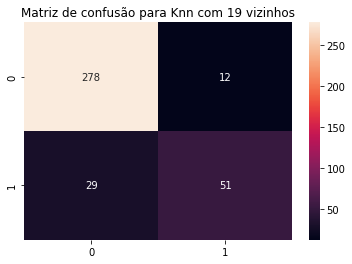

In [139]:
sns.heatmap(confusion_matrix(y_test,y_pred_knn19), annot=True, fmt='d').set_title('Matriz de confusão para Knn com 19 vizinhos');

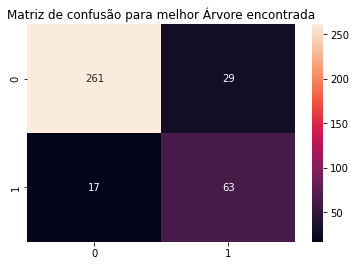

In [138]:
sns.heatmap(confusion_matrix(y_test,y_pred_best), annot=True, fmt='d').set_title('Matriz de confusão para melhor Árvore encontrada');

Iremos escolher o modelo de árvore, pois o nosso foco são os acertos da classe 1, no qual a árvore tem 63 e o knn 51.